In [1]:
import pandas as pd
%matplotlib inline

# What are items are generating the most OOPE?

* The most expensive single presentation is Cinacalcet HCl_Tab 30mg, costing £16,000 per month in OOPE
  * Calcium and Magnesium supplements overall cost £25,000 per month in OOPE with a mean OOPE of £3.30
* The most expensive single OOPE is for Tretinoin Cap 10mg with OOPE cost of £80.99
* The most expensive commonly-prescribed presentation is Solgar_Mag Cit Tab 200mg with mean OOPE per item of £9.86
* At a BNF paragraph level, the most expensive things are:
   * Vitamin D (£67,000 per month)
   * Foods for Special Diets (£52,000 per month)
   * Enteral Nutrition (£43,000 per month)

In [2]:
sql = """
SELECT
  SUM(item_count) AS items,
  SUM(item_pay_oope_amt) AS oope,
  bnf_code,
  bnf_name
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703' AND item_pay_oope_amt > 0
GROUP BY bnf_code, bnf_name
ORDER BY SUM(item_pay_oope_amt) DESC
LIMIT 1000
"""

items = pd.io.gbq.read_gbq(sql, 'ebmdatalab', dialect='standard')

In [3]:
items['oope_per_item'] = items['oope'] / items['items']
items.head(3)

,items,oope,bnf_code,bnf_name,oope_per_item
0,778,16130.23,0905012I0AAAAAA,Cinacalcet HCl_Tab 30mg,20.732943
1,572,12346.06,0606020Z0AAAAAA,Denosumab_Inj 60mg/1ml Pfs,21.584021
2,477,10347.45,130802000BBATA0,Dermacolor_Camouflage Creme,21.692767


In [4]:
items[items['items'] > 100].sort_values('oope_per_item', ascending=False).head(3)

,items,oope,bnf_code,bnf_name,oope_per_item
21,101,2584.71,090402000BBRMA0,Fresubin 2kcal_Drink (6 Flav),25.591188
15,147,3581.08,090402000BBSIA0,Fortisip Compact_Liq (8 Flav),24.361088
13,156,3795.75,0905012I0AAABAB,Cinacalcet HCl_Tab 60mg,24.331731


In [5]:
# Grouped at BNF paragraph level
items['bnf_para'] = items['bnf_code'].str.slice(0,6)
items.groupby('bnf_para').agg(['mean', 'sum']).sort_values(('oope', 'sum'), ascending=False).head(10)

items               oope           oope_per_item             
                 mean   sum         mean       sum          mean          sum
bnf_para                                                                     
090604      59.426966  5289   750.558539  66799.71     20.154450  1793.746029
090401       9.676056  2061   246.200610  52440.73     29.515000  6286.695034
090402      26.000000  2392   464.477391  42731.92     37.859968  3483.117087
130802      93.250000  1119  2107.610000  25291.32     27.762150   333.145797
090501      77.000000  1155  1657.254667  24858.82     23.271590   349.073845
060602     165.750000   663  3767.602500  15070.41     28.796925   115.187701
040202      32.500000   390   877.387500  10528.65     30.282186   363.386238
091000      86.555556   779  1008.082222   9072.74     15.460353   139.143175
090102     176.500000   706  2134.987500   8539.95     17.571041    70.284164
190201    1133.000000  1133  7753.190000   7753.19      6.843063     6.843063

# How does it change over time?

In the period for which we have data, OOPE has decreased overall.  This is because the number of items having OOPE added is decreasing; however, the amount of OOPE being added per item is increasing. See charts below.

In [2]:
sql = """SELECT 
  PARSE_DATE("%Y%m_%d", CONCAT(year_month, "_01")) AS date,
  SUM(item_pay_oope_amt) AS oope,
  SUM(CASE WHEN item_pay_oope_amt > 0 THEN item_count ELSE 0 END) AS oope_items,
  SUM(item_count) AS items
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
GROUP BY
  year_month
ORDER BY
  year_month
"""
dftime = pd.io.gbq.read_gbq(sql, 'ebmdatalab', dialect='standard')

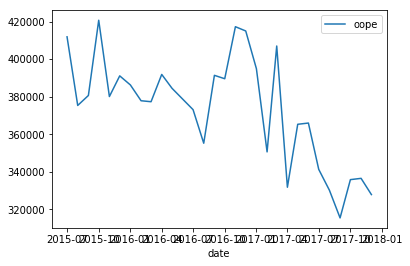

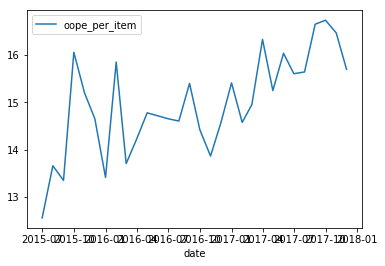

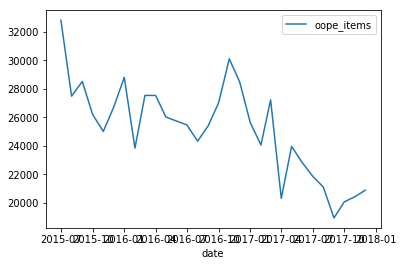

In [3]:
dftime['oope_per_item'] = dftime['oope'] / dftime['oope_items']
dftime.set_index('date')[['oope']].plot()
dftime.set_index('date')[['oope_per_item']].plot()
dftime.set_index('date')[['oope_items']].plot()

In [8]:
# Look up by CCG
# Add a column in bigquery that matches postcode to CCG


sql = """SELECT 
  PARSE_DATE("%Y%m_%d", CONCAT(year_month, "_01")) AS date,
  SUM(item_pay_oope_amt) AS oope,
  SUM(CASE WHEN item_pay_oope_amt > 0 THEN item_count ELSE 0 END) AS oope_items,
  SUM(item_count) AS items
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
  WHERE ccg = '08H'
GROUP BY
  year_month
ORDER BY
  year_month
"""
dftime = pd.io.gbq.read_gbq(sql, 'ebmdatalab', dialect='standard')

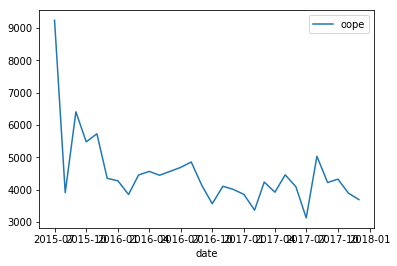

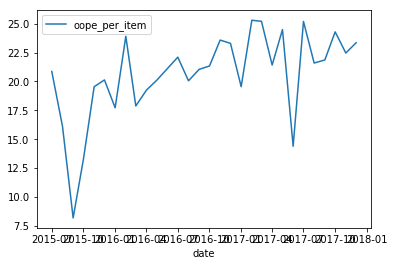

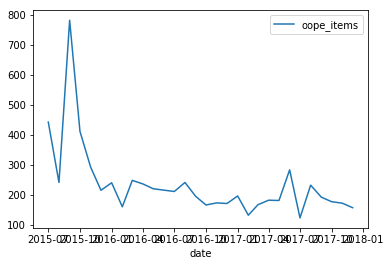

In [7]:
dftime['oope_per_item'] = dftime['oope'] / dftime['oope_items']
dftime.set_index('date')[['oope']].plot()
dftime.set_index('date')[['oope_per_item']].plot()
dftime.set_index('date')[['oope_items']].plot()

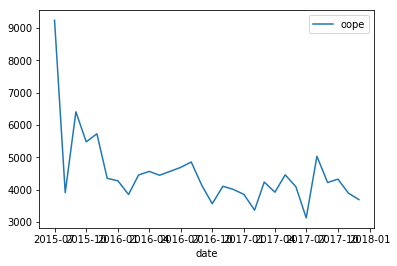

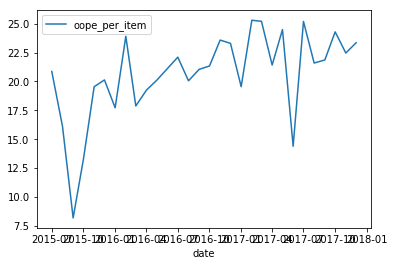

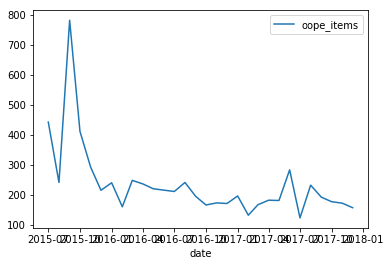

In [3]:
dftime['oope_per_item'] = dftime['oope'] / dftime['oope_items']
dftime.set_index('date')[['oope']].plot()
dftime.set_index('date')[['oope_per_item']].plot()
dftime.set_index('date')[['oope_items']].plot()

## Is there interesting variation for multiples?

In [17]:
# summarise OOPE spending per item, grouped by HQ
sql = """
SELECT
  hq_name,
  COUNT(DISTINCT organisation_code) AS branches,
  SUM(item_count) AS items,
  SUM(actual_cost) AS actual_cost,
  SUM(CASE WHEN item_pay_oope_amt > 0 THEN item_count ELSE 0 END) AS oope_items,
  SUM(item_pay_oope_amt) AS oope,
  MAX(item_pay_oope_amt/item_count) AS max_oope_per_item
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703'
GROUP BY
  hq_name
"""
df = pd.io.gbq.read_gbq(sql, 'ebmdatalab', dialect='standard')

In [12]:
print("In a single month, there were {} branches, represented by {} HQs, prescribing {} items".format(
    df['branches'].sum(),
    df['branches'].count(),
    df['items'].sum()))
print("{} items had OOPE added".format(df['oope_items'].sum()))
print("Total OOPE per month £%s ({})" % (round(df['oope']).sum()))

In a single month, there were 11816 branches, represented by 3762 HQs, prescribing 84970248 items
27224 items had OOPE added
Total OOPE per month £406966.0


## HQs with highest OOPE per item

If we only count HQs with at least 100 OOPE items per month, per branch, then the top-spending (per OOPE item) HQ charges an average of £57 per OOPE item, and 6% of its items have OOPE added.  It charges £10,869 of OOPE in one month.

Of the top 10 HQs, only one was a multiple (i.e. associated with more than contractor/location).


In [23]:
df['oope_per_item'] = df['oope'] / df['items']
df['oope_per_oope_item'] = df['oope'] / df['oope_items']
df['percent_oope_items'] = round(df['oope_items'] / df['items'] * 100)
df['percent_oope_cost'] = round(df['oope'] / df['actual_cost'] * 100)
df = df.sort_values('oope_per_oope_item', ascending=False)
common_oopers = df[df['oope_items']/df['branches'] > 100]

In [24]:
common_oopers.head(13)

,hq_name,branches,items,actual_cost,oope_items,oope,max_oope_per_item,oope_per_item,oope_per_oope_item,percent_oope_items,percent_oope_cost
924,ZAIMRA LTD,1,5196,56741.52,190,10869.00,79.00,2.091801,57.205263,4.0,19.0
2817,C.K & SONS PHARMACY,1,5221,35233.32,135,4079.00,79.00,0.781268,30.214815,3.0,12.0
1570,MEDICX A G LIMITED,1,5459,54335.33,328,9167.59,73.68,1.679353,27.949970,6.0,17.0
2724,MEDI-CALL HEALTHCARE LTD,1,2032,23935.24,125,2923.00,79.00,1.438484,23.384000,6.0,12.0
1193,JM PATEL LTD,1,9196,101498.46,539,11686.98,79.00,1.270876,21.682709,6.0,12.0
2495,SPRING PHARMACY,1,8877,80412.59,115,2480.00,50.00,0.279374,21.565217,1.0,3.0
2964,S&S CHEMISTS,1,15374,91065.44,154,3129.90,61.99,0.203584,20.324026,1.0,3.0
2304,MEDIX-AG LTD,1,8242,46293.35,143,2135.59,90.39,0.259111,14.934196,2.0,5.0
3020,BESPOKE PHARMACY LTD,3,55939,340462.72,1640,19031.46,86.99,0.340218,11.604549,3.0,6.0
592,HUSCHEM LTD,1,8631,57097.70,103,1146.90,36.98,0.132881,11.134951,1.0,2.0


In [30]:
common_oopers.sort_values('percent_oope_cost', ascending=False).head(5)

,hq_name,branches,items,actual_cost,oope_items,oope,max_oope_per_item,oope_per_item,oope_per_oope_item,percent_oope_items,percent_oope_cost
924,ZAIMRA LTD,1,5196,56741.52,190,10869.00,79.00,2.091801,57.205263,4.0,19.0
1570,MEDICX A G LIMITED,1,5459,54335.33,328,9167.59,73.68,1.679353,27.949970,6.0,17.0
2724,MEDI-CALL HEALTHCARE LTD,1,2032,23935.24,125,2923.00,79.00,1.438484,23.384000,6.0,12.0
1193,JM PATEL LTD,1,9196,101498.46,539,11686.98,79.00,1.270876,21.682709,6.0,12.0
2817,C.K & SONS PHARMACY,1,5221,35233.32,135,4079.00,79.00,0.781268,30.214815,3.0,12.0


## Distribution of OOPE per item by HQ
The  majority of HQs have no OOPE at all. All but six have their mean OOPE across all items of under 50p; 87% had a mean OOPE of less than 1p.  In the first chart, note the log scale!

In [ ]:
print("{}% of contracts never charge any OOPE".format(round(df[df['oope'] == 0].count().iloc[0] / df.count().iloc[0] * 100)))

In [207]:
bins = pd.cut(df.oope_per_oope_item, 209)
df.groupby(bins)['oope_per_oope_item'].agg(['count']).head()

,count
oope_per_oope_item,
"(-0.207, 1.02]",12
"(1.02, 2.034]",17
"(2.034, 3.048]",30
"(3.048, 4.063]",21
"(4.063, 5.077]",37


Text(0.5, 0, 'Mean OOPE per item (£)')

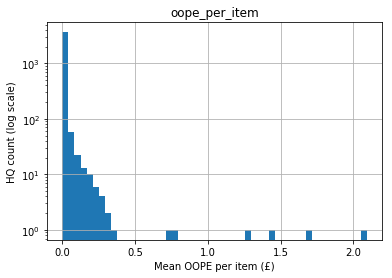

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df.hist(ax=ax, column=['oope_per_item'], bins=50)
ax.set_yscale('log')
ax.set_ylabel('HQ count (log scale)')
ax.set_xlabel('Mean OOPE per item (£)')

Text(0.5, 0, 'Mean OOPE per item that has OOPE (£)')

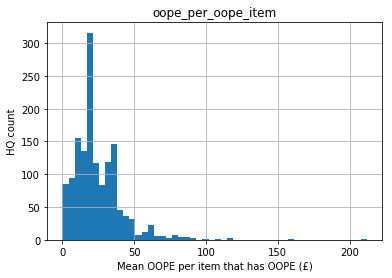

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df.hist(ax=ax, column=['oope_per_oope_item'], bins=50)
ax.set_ylabel('HQ count')
ax.set_xlabel('Mean OOPE per item that has OOPE (£)')

## How does high OOPE covary with group size?

None of the large multiples has high mean OOPEs:

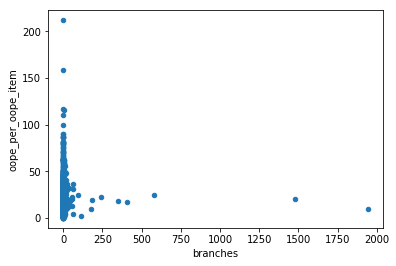

In [98]:
df.plot.scatter(x='branches', y='oope_per_oope_item')

# Is there anything different about the prescriptions being dispensed?

That is, do the HQs with the highest mean OOPE prescribe different amounts of kinds of things from those with the lowest?

In [41]:
print("The 10 HQs with highest mean OOPE account for %s items" % df['items'].head(10).sum())
print("The 10 HQs with lowest mean OOPE account for %s items" % df['items'].tail(10).sum())

The 10 HQs with highest mean OOPE account for 109981 items
The 10 HQs with lowest mean OOPE account for 77398 items


## Investigate lowest and highest HQs

In [115]:
sql = """
SELECT
  item_pay_dr_nic,
  item_count,
  item_pay_oope_amt,
  bnf_code,
  bnf_name,
  name,
  postcode
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703' AND 
(%s)
"""
hq_names = []
for name in list(common_oopers.hq_name.head(10)):
    hq_names.append("hq_name = '%s'" % name)
highest = pd.io.gbq.read_gbq(sql % " OR ".join(hq_names), 'ebmdatalab', dialect='standard')

In [106]:
sql = """
SELECT
  item_pay_dr_nic,
  item_count,
  item_pay_oope_amt,
  bnf_code,
  bnf_name,
  name,
  postcode
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703' AND 
(%s)
"""
hq_names = []
for name in list(df.hq_name.tail(10)):
    hq_names.append("hq_name = '%s'" % name)
lowest = pd.io.gbq.read_gbq(sql % " OR ".join(hq_names), 'ebmdatalab', dialect='standard')

### The 10 HQs with highest OOPE per items
...are accounted for by 12 dispensers, with a mean item count of 10300, mean NIC of £73,000, and mean OOPE of £5550. 3.5% of prescription items come with OOPEs (compared with 0 for the best dispensers). In a single month they charged £69,000 in OOPE, equivalent to a 9% surcharge (the highest being 22%). 67% of dispensers have NO OOPE.

In [127]:
totals = highest.groupby("name").sum().sort_values('item_pay_oope_amt', ascending=False)
totals['uplift'] = totals['item_pay_oope_amt']/totals['item_pay_dr_nic']
totals

,item_pay_dr_nic,item_count,item_pay_oope_amt,uplift
name,,,,
STONE PHARMACY,96587.59,9196,11686.98,0.120999
RYANS PHARMACY,49271.80,5196,10869.00,0.220593
BIRKWOOD PHARMACY,106179.76,19749,10341.15,0.097393
WILBERFORCE PHARMACY ONLINE,48620.37,5459,9167.59,0.188555
MARISCO PHARMACY,158056.87,20486,6286.61,0.039774
C K & SONS,33487.40,5221,4079.00,0.121807
S&S CHEMISTS,93973.56,15374,3129.90,0.033306
RYANS LOCAL,22613.05,2032,2923.00,0.129262
SPRING PHARMACY LTD,83883.55,8877,2480.00,0.029565


In [130]:
totals.mean()

item_pay_dr_nic      73369.895000
item_count           10347.250000
item_pay_oope_amt     5554.118333
uplift                   0.089617
dtype: float64

### The 10  HQs with lowest OOPE per item 
...are accounted for by 10 dispensers, with a mean item count of 7739, mean NIC of £58,000, and mean OOPE of £0 (indeed, a maximum OOPE of £0)

In [131]:
lowest.head(1)

,item_pay_dr_nic,item_count,item_pay_oope_amt,bnf_code,bnf_name,name,postcode
0,5.24,2,0.0,0304010G0BCACAB,Piriton_Syr 2mg/5ml,GOSPEL LANE PHARMACY,B27 7AJ


In [132]:
lowest.groupby("name").sum()

,item_pay_dr_nic,item_count,item_pay_oope_amt
name,,,
GIBSONS PHARMACY,86639.07,12992,0.0
GOSPEL LANE PHARMACY,84491.16,9294,0.0
HALTON PHARMACY,28602.85,4615,0.0
HEATH PHARMACY,25253.77,4261,0.0
MEDIBANK PHARMACY,24870.48,4609,0.0
MILFORD PHARMACY,44619.98,5486,0.0
MONKBAR PHARMACY,83188.79,7807,0.0
PEAK PHARMACY,22131.30,3576,0.0
VERWOOD PHARMACY,80653.13,11322,0.0


In [133]:
lowest.groupby("name").sum().mean()

item_pay_dr_nic      50568.136
item_count            6756.600
item_pay_oope_amt        0.000
dtype: float64

## Do the highest and lowest dispense very different things?

Descriptive statistics for the "highest" and "lowest" groups are very similar.

The mean OOPE per item (where OOPE was added at all) in the "highest" group was £36 (and 0 in the "lowest"). The "highest" group had about 120 presentations-with-OOPE not seen in the "lowest" group; for those presentations, the mean OOPE per item was £41; OOPE presentations also dispensed in the "lowest" group had a mean OOPE per item of £26.

Therefore it looks like the "highest" group do routinely add more OOPE for everything; but a lot more for things only they see.




In [186]:
import numpy as np
highest['oope_count'] = np.where(highest['item_pay_oope_amt'] > 0, highest['item_count'], 0)
df3 = highest.groupby('bnf_name').sum()
df3['oope_per_oope_item'] = df3['item_pay_oope_amt'] / df3['oope_count']
highest_presentations = df3.sort_values('oope_per_oope_item', ascending=False)
highest_presentations[~np.isnan(highest_presentations['oope_per_oope_item'])].head()

,item_pay_dr_nic,item_count,item_pay_oope_amt,oope_count,oope_per_oope_item
bnf_name,,,,,
Coloplast_Sensura Mio Maxi DrnblBag Grey+Window C/Fit10-55mm,298.89,1,86.99,1,86.99
Promixin_Pdr For Neb 1mega u,672.00,2,158.38,2,79.19
Nutrison_Energy M/Fibre Liq (Vanilla),459.90,1,79.00,1,79.00
Loprofin_L/P Fusilli,8.94,1,79.00,1,79.00
Symbicort_Turbohaler 100mcg/6mcg (120 D),396.00,11,79.00,1,79.00


The following shows that in the HQs with the highest OOPE per items, 3746 different presentations were dispensed, of which 286 had OOPE, with a mean OOPE per item of £36

In [144]:
highest_presentations.describe()

,item_pay_dr_nic,item_count,item_pay_oope_amt,oope_count,oope_per_oope_item
count,3885.000000,3885.000000,3885.000000,3885.000000,286.000000
mean,226.625158,31.960618,17.155578,0.893694,36.552648
std,696.446448,142.008236,139.804966,10.403610,19.573289
min,0.140000,1.000000,0.000000,0.000000,0.152181
25%,16.460000,1.000000,0.000000,0.000000,25.283333
50%,51.630000,4.000000,0.000000,0.000000,36.980000
75%,174.520000,13.000000,0.000000,0.000000,39.500000
max,14929.820000,3385.000000,3476.120000,486.000000,86.990000


And the next table shows in the HQs with the lowest OOPE per items, 3368 items were dispensed with no OOPE

In [155]:
df3 = lowest.groupby('bnf_name').sum()
lowest['oope_count'] = np.where(lowest['item_pay_oope_amt'] > 0, lowest['item_count'], 0)
df3 = lowest.groupby('bnf_name').sum()
df3['oope_per_oope_item'] = df3['item_pay_oope_amt'] / df3['oope_count']
lowest_presentations = df3.sort_values('oope_per_oope_item', ascending=False)
lowest_presentations.describe()

,item_pay_dr_nic,item_count,item_pay_oope_amt,oope_count,oope_per_oope_item
count,3222.000000,3222.000000,3222.0,3222.0,0.0
mean,156.946418,20.970205,0.0,0.0,NaN
std,396.685053,81.933010,0.0,0.0,NaN
min,0.190000,1.000000,0.0,0.0,NaN
25%,14.980000,1.000000,0.0,0.0,NaN
50%,44.930000,3.000000,0.0,0.0,NaN
75%,138.450000,11.000000,0.0,0.0,NaN
max,7144.200000,1715.000000,0.0,0.0,NaN


We can combine the two tables together, to find presentations common to both high and low OOPE dispensers.

In [159]:
# Now compare these
#baddy_presentations = df3[(df3['oope_per_item'] > 0) & (df3['item_count'] > 10)]
compared = highest_presentations.merge(
    lowest_presentations,
    left_index=True,
    right_index=True,
    suffixes=["_high", "_low"],
    how="outer"
)
compared.sort_values("oope_per_oope_item_high", ascending=False).head()

,item_pay_dr_nic_high,item_count_high,item_pay_oope_amt_high,oope_count_high,oope_per_oope_item_high,item_pay_dr_nic_low,item_count_low,item_pay_oope_amt_low,oope_count_low,oope_per_oope_item_low
bnf_name,,,,,,,,,,
Coloplast_Sensura Mio Maxi DrnblBag Grey+Window C/Fit10-55mm,298.89,1.0,86.99,1.0,86.99,NaN,NaN,NaN,NaN,NaN
Promixin_Pdr For Neb 1mega u,672.00,2.0,158.38,2.0,79.19,NaN,NaN,NaN,NaN,NaN
Nutrison_Energy M/Fibre Liq (Vanilla),459.90,1.0,79.00,1.0,79.00,61.32,2.0,0.0,0.0,NaN
Loprofin_L/P Fusilli,8.94,1.0,79.00,1.0,79.00,NaN,NaN,NaN,NaN,NaN
Symbicort_Turbohaler 100mcg/6mcg (120 D),396.00,11.0,79.00,1.0,79.00,561.00,13.0,0.0,0.0,NaN


In [160]:
import numpy as np
good_only = compared[np.isnan(compared['item_count_high'])]
bad_only = compared[np.isnan(compared['item_count_low'])]
both = compared[(~np.isnan(compared['item_count_low'])) & (~np.isnan(compared['item_count_high']))]

There are 758 presentations only prescribed in the dispensaries with the lowest OOPE:

In [161]:
good_only.describe()

,item_pay_dr_nic_high,item_count_high,item_pay_oope_amt_high,oope_count_high,oope_per_oope_item_high,item_pay_dr_nic_low,item_count_low,item_pay_oope_amt_low,oope_count_low,oope_per_oope_item_low
count,0.0,0.0,0.0,0.0,0.0,758.000000,758.000000,758.0,758.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,68.327744,1.742744,0.0,0.0,NaN
std,NaN,NaN,NaN,NaN,NaN,121.116004,1.614349,0.0,0.0,NaN
min,NaN,NaN,NaN,NaN,NaN,0.220000,1.000000,0.0,0.0,NaN
25%,NaN,NaN,NaN,NaN,NaN,9.062500,1.000000,0.0,0.0,NaN
50%,NaN,NaN,NaN,NaN,NaN,25.860000,1.000000,0.0,0.0,NaN
75%,NaN,NaN,NaN,NaN,NaN,70.355000,2.000000,0.0,0.0,NaN
max,NaN,NaN,NaN,NaN,NaN,1256.400000,15.000000,0.0,0.0,NaN


...and 117 presentations-that-have-OOPE which only prescribed in those with the highest OOPE

In [162]:
bad_only[bad_only['item_pay_oope_amt_high'] > 0].describe()

,item_pay_dr_nic_high,item_count_high,item_pay_oope_amt_high,oope_count_high,oope_per_oope_item_high,item_pay_dr_nic_low,item_count_low,item_pay_oope_amt_low,oope_count_low,oope_per_oope_item_low
count,117.000000,117.000000,117.000000,117.000000,117.000000,0.0,0.0,0.0,0.0,0.0
mean,192.259573,3.666667,98.354444,3.128205,41.470097,NaN,NaN,NaN,NaN,NaN
std,237.674093,5.333693,119.587144,5.066010,16.411073,NaN,NaN,NaN,NaN,NaN
min,2.420000,1.000000,36.980000,1.000000,9.523810,NaN,NaN,NaN,NaN,NaN
25%,41.940000,1.000000,36.980000,1.000000,36.980000,NaN,NaN,NaN,NaN,NaN
50%,98.260000,2.000000,73.960000,1.000000,36.980000,NaN,NaN,NaN,NaN,NaN
75%,268.320000,3.000000,110.940000,2.000000,40.000000,NaN,NaN,NaN,NaN,NaN
max,1078.580000,30.000000,732.860000,29.000000,86.990000,NaN,NaN,NaN,NaN,NaN


...and 2498 in both, of which 192 have any OOPE:

In [163]:
both[both['item_pay_oope_amt_high'] > 0].describe()

,item_pay_dr_nic_high,item_count_high,item_pay_oope_amt_high,oope_count_high,oope_per_oope_item_high,item_pay_dr_nic_low,item_count_low,item_pay_oope_amt_low,oope_count_low,oope_per_oope_item_low
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.0,169.0,0.0
mean,1133.642308,56.189349,326.283728,18.378698,33.148260,539.685976,26.408284,0.0,0.0,NaN
std,2179.961654,138.535494,578.767144,46.437475,20.867779,1087.537552,65.862990,0.0,0.0,NaN
min,8.080000,1.000000,9.920000,1.000000,0.152181,3.640000,1.000000,0.0,0.0,NaN
25%,141.600000,5.000000,61.990000,2.000000,18.246667,48.000000,2.000000,0.0,0.0,NaN
50%,417.600000,15.000000,79.000000,5.000000,35.909091,128.800000,5.000000,0.0,0.0,NaN
75%,1097.600000,52.000000,237.000000,14.000000,39.500000,446.910000,21.000000,0.0,0.0,NaN
max,14929.820000,1451.000000,3476.120000,486.000000,79.000000,7144.200000,688.000000,0.0,0.0,NaN


In [174]:
# Total OOPE spent per item, for things prescribed in both places - top 5 (of 192 with any OOPE)
both['oope_per_oope_item_high'].sort_values(ascending=False).head()

bnf_name
Ensure Plus Advance_Liq (5 Flav)     79.0
Complan_Shake Pdr Sach 57g (Choc)    79.0
Aveeno_Crm                           79.0
Janumet_Tab 50mg/1g                  79.0
Nifedipine_Cap 10mg M/R              79.0
Name: oope_per_oope_item_high, dtype: float64

In [175]:
# Total OOPE spent per item, for things prescribed in only high-oope places - top 5 (of 103 with any OOPE)
bad_only['oope_per_oope_item_high'].sort_values(ascending=False).head()

bnf_name
Coloplast_Sensura Mio Maxi DrnblBag Grey+Window C/Fit10-55mm    86.99
Promixin_Pdr For Neb 1mega u                                    79.19
Calshake_Pdr Sach 87g (Vanilla)                                 79.00
Fresubin Energy Fibre_Liq (6 Flav)                              79.00
Fortisip Compact Fibre_Liq S/Pack                               79.00
Name: oope_per_oope_item_high, dtype: float64

# Finally, there is a weird £36.98 thing going on
I've noticed a lot of the things with high OOPE have identical OOPE-per item - for example, £20.99, £36.98, and £79, all examined here.

These appear to be fixed OOPE prices, regardless of the item - for example, the relatively common `Bio-Vitamin D3_Cap 800u` costs 44p per pack, but £36.98 fixed OOPE.

At the other end, an unusual special like `Levocarnitine_Oral Soln Paed 1.5g/5ml` costs £1571 per pack, and still £36.98 fixed OOPE.



In [43]:
sql = """
SELECT
  *
FROM
  dispensers.dispensing_with_metadata
WHERE
  (item_pay_oope_amt / item_count = 36.98
    OR (item_pay_oope_amt / item_count) = 20.99 
    OR (item_pay_oope_amt / item_count) = 79.0)
  AND year_month = '201703'
"""
df = pd.io.gbq.read_gbq(sql, 'ebmdatalab', dialect='standard')

In [44]:
df['oope_per_nic'] = (df['item_pay_oope_amt'] / df['item_count']) / df['item_pay_dr_nic']

In [45]:
print("A total of {} spent in OOPE for items with OOPE at these three levels".format(df['item_pay_oope_amt'].sum()))

A total of 50145.39 spent in OOPE for items with OOPE at these three levels


In [42]:
df[['bnf_name', 'bnf_code', 'item_pay_dr_nic', 'item_pay_oope_amt', 'oope_per_nic']].sort_values('oope_per_nic', ascending=False).head()

,bnf_name,bnf_code,item_pay_dr_nic,item_pay_oope_amt,oope_per_nic
16301,Aloe Pura_Aloe Vera Max Strgh Juice,091104000BBJUA0,0.01,20.99,2099.000000
597,Lamb_Pure Fish Oil Cap 1100mg,090601100BBGSA0,0.10,36.98,369.800000
21117,Fluoxetine HCl_Tab Disper 20mg S/F,0403030E0AAAKAK,0.12,20.99,174.916667
15597,Lamb_Nicotinamide Tab 250mg (8054),090602200BBBHA0,0.31,36.98,119.290323
5164,Ergocalciferol_Tab 12.5mcg,0906040N0AAEWEW,0.37,36.98,99.945946


The most common of these:

In [38]:
df.groupby('bnf_name').agg('sum')['item_count'].sort_values(ascending=False).head(10)

bnf_name
Dermacolor_Camouflage Creme        1169
Dermacolor_Fixing Pdr               758
Juvela_G/F Fresh Loaf Wte (Cut)     536
Cyanocobalamin_Tab 1mg M/R          521
Veil_Cover Crm                      477
Veil_Finishing Pdr                  414
Unspec Drug Code_                   383
Vega_ZM3 Multivit/Min V/Cap         346
Solgar_Vit D3 Tab 1,000u            303
Solgar_Mag Cit Tab 200mg            275
Name: item_count, dtype: int64

## What DT categories are the OOPE items in?
Only Category C items can be claimed, but:

In [46]:
sql = """
SELECT
  vmpp,
  tariff_category,
  d.name,
  d.hq_name,
  d.bnf_code,
  item_count,
  item_pay_oope_amt,
  actual_cost
FROM
  dispensers.dispensing_with_metadata d
LEFT JOIN
  `dmd.dt_viewer` v
ON
  d.bnf_code = v.bnf_code
WHERE
  year_month = '201703'
  AND v.date = '2017-03-01'
  AND item_pay_oope_amt > 0
  AND tariff_category != "Part VIIIA Category C"
"""
df = pd.io.gbq.read_gbq(sql, 'ebmdatalab', dialect='standard')
df.head()

,vmpp,tariff_category,name,hq_name,bnf_code,item_count,item_pay_oope_amt,actual_cost
0,Simvastatin 20mg tablets 28 tablet,Part VIIIA Category M,BOOTS UK LIMITED,BOOTS GROUP PLC,0212000Y0AAABAB,197,24.95,205.53
1,Paracetamol 250mg/5ml oral suspension sugar fr...,Part VIIIA Category A,KAMSONS PHARMACY,WAREMOSS LTD,0407010H0AABGBG,17,6.50,78.90
2,Sulpiride 200mg/5ml oral solution sugar free 1...,Part VIIIA Category A,LLOYDSPHARMACY,LLOYDS PHARMACY LTD,0402010U0AAAEAE,3,43.00,256.75
3,Sildenafil 25mg tablets 4 tablet,Part VIIIA Category M,YOUR LOCAL BOOTS PHARMACY,BOOTS GROUP PLC,0704050Z0AAABAB,1,20.00,23.60
4,Haloperidol 5mg/5ml oral solution sugar free 1...,Part VIIIA Category A,MAGSON PHARMACY,ADAM MYERS LTD,0402010J0AABCBC,2,11.99,71.91


In [47]:
print("A total of {} OOPE was paid on things that shouldn't".format(df.item_pay_oope_amt.sum()))

A total of 1165.0700000000002 OOPE was paid on things that shouldn't


In [ ]:
df.groupby('tariff_category').